# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.


In [1]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [2]:
from ema_workbench import MultiprocessingEvaluator, ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000
n_policies = 10

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*

In [3]:
experiments, outcomes = results

In [4]:
experiments.head()

,b,delta,mean,q,stdev,0,1,10,11,12,...,93,94,95,96,97,98,99,scenario,policy,model
0,0.226224,0.970547,0.027319,3.872903,0.002965,0.029189,0.084199,0.051313,0.02011,0.072655,...,0.083837,0.011737,0.033437,0.006872,0.086067,0.023064,0.079572,0,0,lakeproblem
1,0.270902,0.965437,0.010299,2.170984,0.001674,0.029189,0.084199,0.051313,0.02011,0.072655,...,0.083837,0.011737,0.033437,0.006872,0.086067,0.023064,0.079572,1,0,lakeproblem
2,0.247250,0.964961,0.040075,2.159455,0.004130,0.029189,0.084199,0.051313,0.02011,0.072655,...,0.083837,0.011737,0.033437,0.006872,0.086067,0.023064,0.079572,2,0,lakeproblem
3,0.308293,0.979950,0.012485,2.283549,0.002121,0.029189,0.084199,0.051313,0.02011,0.072655,...,0.083837,0.011737,0.033437,0.006872,0.086067,0.023064,0.079572,3,0,lakeproblem
4,0.346859,0.984501,0.027261,3.330304,0.003085,0.029189,0.084199,0.051313,0.02011,0.072655,...,0.083837,0.011737,0.033437,0.006872,0.086067,0.023064,0.079572,4,0,lakeproblem


In [5]:
cleaned_experiments = experiments.drop(labels=[l.name for l in lake_model.levers],
                                       axis=1)

3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability

In [6]:
from ema_workbench.analysis import prim

data = outcomes['reliability']

y = data < np.percentile(data, 10)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8)
box1 = prim_alg.find_box()

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 869 cases of interest
[MainProcess/INFO] mean: 0.86328125, mass: 0.0512, coverage: 0.5086306098964327, density: 0.86328125 restricted_dimensions: 4


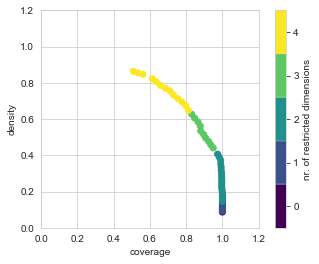

In [7]:
box1.show_tradeoff()
plt.show()

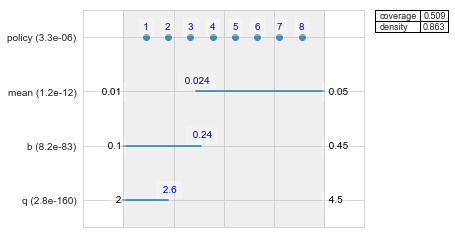

In [8]:
box1.inspect(style='graph')
plt.show()

In [12]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 9488 points remaining, containing 427 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.4990138067061144, returning dump box


policy [1, 2, 3, 4, 5, 6, 7, 8, 0, 9]


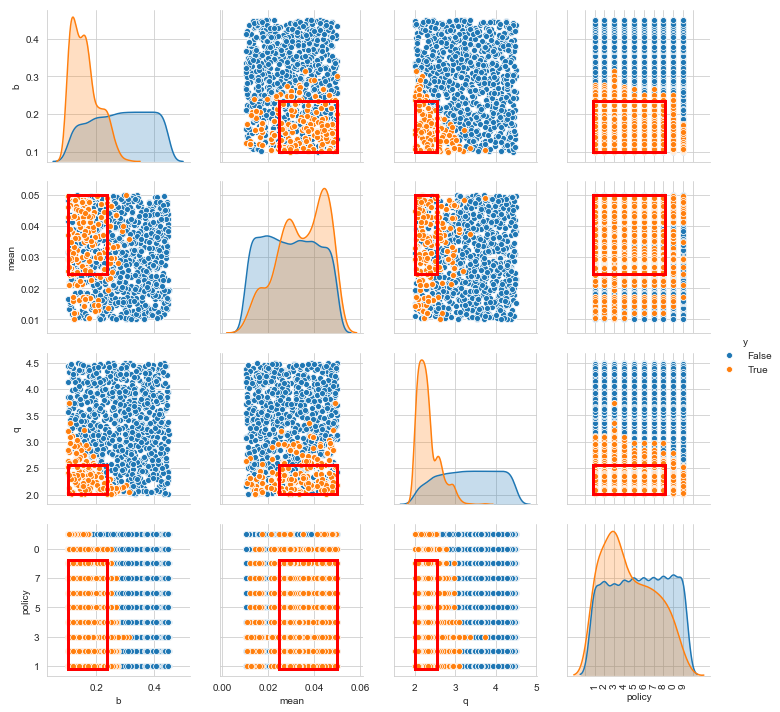

In [13]:
box1.show_pairs_scatter()

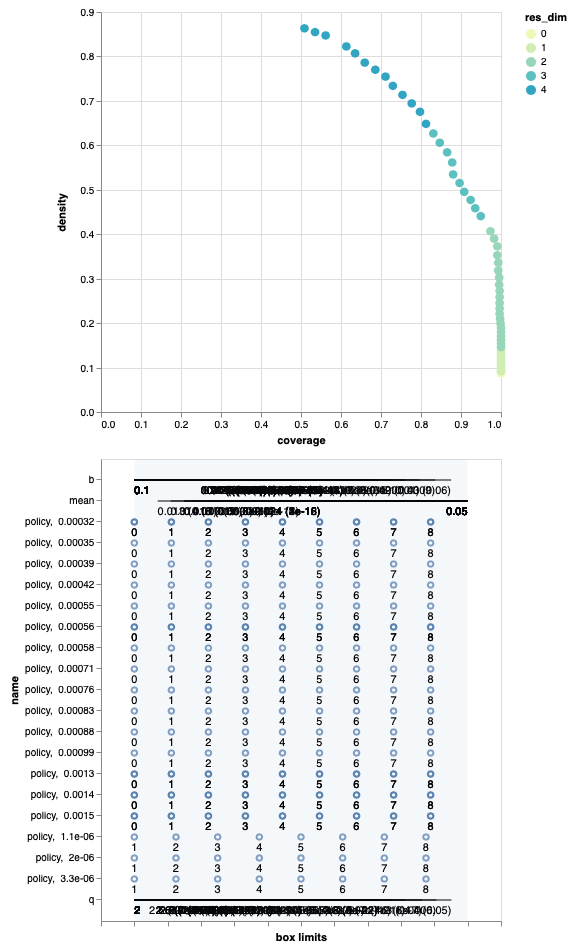

In [16]:
box1.inspect_tradeoff()

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

In [14]:
from ema_workbench.analysis import dimensional_stacking

[MainProcess/INFO] model dropped from analysis because only a single category


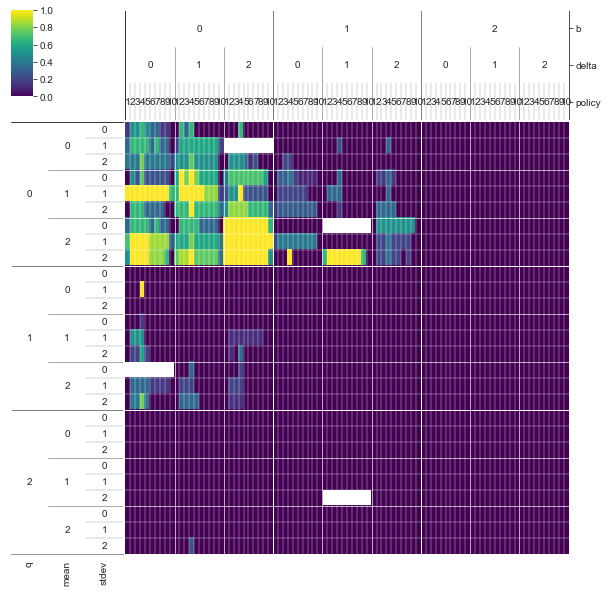

In [15]:
dimensional_stacking.create_pivot_plot(cleaned_experiments, y)
plt.show()

looking at this graph, we have a few white spaces, so there is an argument to be made that we should run quite a bit more than 1000 runs.

In [23]:
n_scenarios = 10000
n_policies = 10

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10000 scenarios * 10 policies * 1 model(s) = 100000 experiments
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 30000 cases completed
[MainProcess/INFO] 40000 cases completed
[MainProcess/INFO] 50000 cases completed
[MainProcess/INFO] 60000 cases completed
[MainProcess/INFO] 70000 cases completed
[MainProcess/INFO] 80000 cases completed
[MainProcess/INFO] 90000 cases completed
[MainProcess/INFO] 100000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


[MainProcess/INFO] model dropped from analysis because only a single category


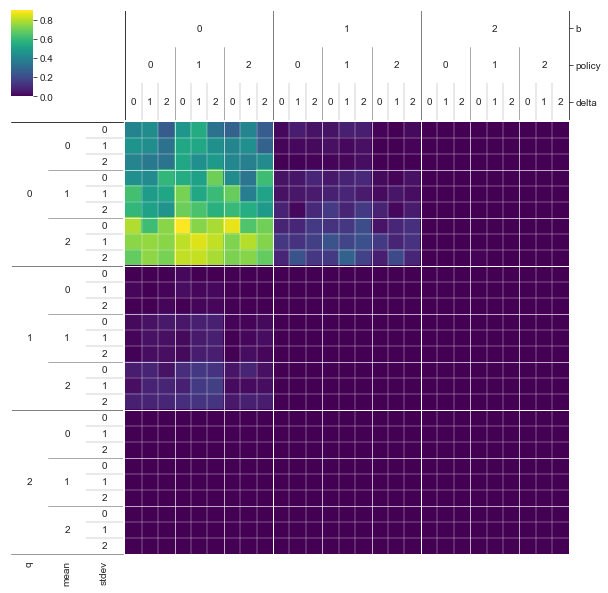

In [24]:
experiments, outcomes = results
cleaned_experiments = experiments.drop(labels=[l.name for l in lake_model.levers], axis=1)

data = outcomes['reliability']
y = data < np.percentile(data, 10)

dimensional_stacking.create_pivot_plot(cleaned_experiments, y)
plt.show()